# Wstęp
Zadanie 10 jest pierwszą częścią zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2. Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3. Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem pierwszego etapu prac jest zapoznanie się z podstawową siecią rekurencyjną LSTM. Ze względu na fakt, że model ten będzie wykorzystany do analizy emocji tekstu, w ramach teorii do zadania zostanie omówiony podstawowy mechanizm konwersji słów w tekście do postaci wektorów dystrybucyjnych (tzw. word embeddings) na podstawie rozwiązania o nazwie `fastText`. Modele będą budowane na ogólnodostępnym zbiorze `TweetEval`, zawierającym podzbiory ręcznie anotowanych tweetów przy pomocy etykiet odnoszących się do następujących zjawisk: 

1) emocje (emotion), 
2) emotikony (emoji), 
3) ironia (irony), 
4) mowa nienawiści (hate speech),
 5) mowa ofensywna (offensive language), 
6) wydźwięk (sentiment), 
7) nastawienie (stance). 

# Warunki zaliczenia

Do zaliczenia pierwszego etapu należy utworzyć następujące modele dla min. 2 wybranych zjawisk:

1.   Model bazowy (regresja logistyczna).
2.   Model rekurencyjny oparty o sieć LSTM.

Wytrenowane modele będą wykorzystane w 2 etapie, dlatego proszę je zachować.

# Wektory dystrybucyjne

W przetwarzaniu języka naturalnego, o wektorach dystrybucyjnych (inaczej osadzeniach lub zanurzeniach, ang. word embeddings) mówi się w kontekście reprezentacji słów w tekście, zazwyczaj w postaci wektora liczb rzeczywistych, który koduje znaczenie słowa. Hipoteza dystrybucyjna, u podstawy której leży większość metod reprezentacji, mówi o tym, że słowa, które często współwystępują, mają podobne znaczenie. Wektory dystrybucyjne można uzyskać za pomocą zestawu technik modelowania języka, w których słowa lub frazy są mapowane do wektorów liczb rzeczywistych. Z reguły polega to na matematycznym zanurzeniu z przestrzeni o wielu wymiarach opisujących słowo (konteksty) do ciągłej przestrzeni wektorowej o znacznie mniejszym wymiarze.

Metody generowania tego odwzorowania obejmują sieci neuronowe, redukcję wymiarowości na macierzy współwystępowania słów, modele probabilistyczne lub jawną reprezentację w kontekście, w którym pojawiają się słowa. Wektory dystrybucyjne, używane jako podstawowa reprezentacja wejściowa tekstu, okazały się istotnie poprawiać jakość w wielu zadaniach NLP, takich jak np. rozpoznawanie nazw własnych, określanie części mowy, rozpoznawanie dziedziny tekstu, czy też rozpoznawanie wydźwięku i emocji w tekście. 

# fastText

[fastText](https://fasttext.cc/) jest biblioteką do efektywnego uczenia modeli reprezentacji wektorowych słów oraz do budowania klasyfikatorów tekstu. Modele językowe można budować z wykorzystaniem dwóch popularnych technik: [Continuous Bag of Words](https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html) oraz [Skip-Gram](https://towardsdatascience.com/skip-gram-nlp-context-words-prediction-algorithm-5bbf34f84e0c). 

## Instalacja

Pobranie repozytorium projektu:


In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, List, Dict
from matplotlib import pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import csv

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
def plot_results(results, ncols=2, patience=0):
    num_rows = len(results)
    fig, axes = plt.subplots(nrows=num_rows, ncols=ncols, figsize=(14, 5 * num_rows))
    if num_rows == 1:
        axes = [axes]
    if ncols == 1:
        axes = [[ax] for ax in axes]

    for ax, (key, values) in zip(axes, results.items()):
        epochs = range(1, len(values['train_loss']) + 1)
        stop_epoch = None
        if patience > 0:
            num_epochs = len(epochs)
            stop_epoch = num_epochs - patience
            print(f"Early stopping at epoch {stop_epoch}")

        # Przekształcanie tensorów do CPU i konwersja na listy
        train_loss = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['train_loss']]
        train_acc = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['train_acc']]
        
        ax[0].plot(epochs, train_loss, label='Train Loss')
        # if test loss exists, plot it
        if 'test_loss' in values:
            test_loss = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['test_loss']]
            ax[0].plot(epochs, test_loss, label='Test Loss')
        ax[0].set_title(f"{key} Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        if stop_epoch:
            ax[0].axvline(x=stop_epoch, linestyle='--', label='Early Stopping')
            ax[0].legend()

        if ncols == 1:
            continue
        
        test_acc = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['test_acc']]
        ax[1].plot(epochs, train_acc, label='Train Accuracy')
        ax[1].plot(epochs, test_acc, label='Test Accuracy')
        ax[1].set_title(f"{key} Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

        if stop_epoch:
            ax[1].axvline(x=stop_epoch, linestyle='--', label='Early Stopping')
            ax[1].legend()

    plt.tight_layout()
    plt.show()


In [4]:
!cd models && git clone https://github.com/facebookresearch/fastText.git

fatal: destination path 'fastText' already exists and is not an empty directory.


Instalacja biblioteki:

In [5]:
!cd models && cd fastText && mkdir build && cd build && cmake ..  && make && make install

mkdir: build: File exists


Instalacja API do Pythona:

In [6]:
!cd models && cd fastText && pip install .

Processing /Users/ewojcik/Code/pwr/GSN/10/models/fastText
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-macosx_14_0_arm64.whl size=282630 sha256=4407b75c081824207167528a9cfc0a234c7922238bec4c32a7a654b8b4f02845
  Stored in directory: /private/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/pip-ephem-wheel-cache-_uyga23i/wheels/a3/41/cd/a705391f44f07493eea2e7185c05e886e89dcc86b59bbb22b0
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


# Dane do etapu nr 1

## Korpus 
Korpus (zbiór dokumentów) do realizacji etapu nr 1 pochodzi z repozytorium [TweetEval](https://github.com/cardiffnlp/tweeteval). Repozytorium zawiera 7 różnorodnych zbiorów danych, zawierających zanonimizowane wpisy z [Twittera](https://twitter.com), anotowane następującymi zjawiskami: 
1) emocje (emotion), 
2) emotikony (emoji), 
3) ironia (irony), 
4) mowa nienawiści (hate speech), 
5) mowa ofensywna (offensive language), 
6) wydźwięk (sentiment), 
7) nastawienie (stance). 

In [7]:
# należy wgrać plik z katalogu "dane" o nazwie tweeteval.7z

In [8]:
# !7za x tweeteval.7z

## Zawartość korpusu

W katalogu głównym (tweeteval) znajdują się następujące elementy:
*   `datasets` - katalog ze zbiorami danych
   * `emotion` - tweety anotowane emocjami 
     * `mapping.txt` - identyfikatory etykiet oraz ich opis
     * `train_text.txt` - wpisy z Twittera (część ucząca)
     * `train_labels.txt` - etykiety wpisów z Twittera (część ucząca)
     * `test_*.txt, valid_*.txt` - j.w. (część testowa i walidacyjna)
   * `emoji` - tweety anotowane emotikonami
   * `...` - katalogi zawierające tweety anotowane pozostałymi zjawiskami
*   `predictions` - katalog z przykładowymi predykcjami
   * `emotion.txt` - etykiety modelu predykcyjnego dla części testowej danych `emotion`
   * `emoji.txt` - j.w. dla cz. testowej danych `emoji`
   * `...` - j.w. dla pozostałych danych
*   `evaluation_script.py` - skrypt do ewaluacji 

## Model języka

Na potrzeby zadania został przygotowany model Skip-Gram reprezentacji wektorowej słów, zbudowany na wielkim korpusie tweetów dotyczących kursu BTC. Wersja binarna tego modelu dostępna jest w 2 wariantach:
* wektory 100-elementowe (1.7GB, fasttext_tweetmodel_btc_sg_100_en.bin)
* wektory 20-elementowe (350MB, fasttext_tweetmodel_btc_sg_20_en.bin)

Na potrzeby prezentacji przykładowego rozwiązania zostanie wykorzystany mniejszy model. Do realizacji ostatecznego rozwiązania należy wykorzystać większy model. 



# Model bazowy rozpoznawania emocji

Model bazowy, zbudowany z wykorzystaniem narzędzia fastText (oparty o regresję logistyczną), będzie punktem wyjścia do porównania się z modelami opartymi o sieci LSTM, których skonstruowanie i ewaluacja na wybranych zadaniach będzie celem etapu nr 1. 

Pobranie mniejszego modelu reprezentacji języka tweetów:


In [9]:
# należy wgrać plik z katalogu "dane" o nazwie fasttext_tweetmodel_btc_sg_20_en.bin
# import file from: dane laboratoriun/fasttext_tweetmodel_btc_sg_20_en.bin



Wydobycie słownika wektorów z binarnego modelu języka:

In [10]:
!python models/fastText/python/doc/examples/bin_to_vec.py models/fasttext_tweetmodel_btc_sg_20_en.bin > models/fasttext_tweetmodel_btc_sg_20_en.vec

Dodanie prefiksu `__label__` do etykiet zbioru `emotion`:

In [11]:
!sed 's/^/__label__/g' data/tweeteval/datasets/emotion/train_labels.txt > outs/train_labels_emo.txt
!sed 's/^/__label__/g' data/tweeteval/datasets/emotion/test_labels.txt > outs/test_labels_emo.txt
!sed 's/^/__label__/g' data/tweeteval/datasets/emotion/val_labels.txt > outs/val_labels_emo.txt

Przygotowanie zbioru uczącego, testowego i walidacyjnego w formacie `fastText`:

In [12]:
!paste -d " " data/tweeteval/datasets/emotion/train_text.txt outs/train_labels_emo.txt > outs/train_emo.txt
!paste -d " " data/tweeteval/datasets/emotion/test_text.txt outs/test_labels_emo.txt > outs/test_emo.txt
!paste -d " " data/tweeteval/datasets/emotion/val_text.txt outs/val_labels_emo.txt > outs/val_emo.txt

Trenowanie modelu z wykorzystaniem wejścia `train_emo.txt`, z określeniem wyjściowej nazwy modelu `emo_model`, dla wektorów słów o wymiarze `20`, z wykorzystaniem pretrenowanych wektorów z pliku `fasttext_tweetmodel_btc_sg_20_en.vec` i z uruchomieniem dostrajania hiperparametrów na zbiorze walidacyjnym `val_emo.txt`:

In [13]:
!~/Code/pwr/GSN/10/models/fastText/fasttext supervised -input outs/train_emo.txt -output models/emo_model -dim 20 -pretrainedVectors models/fasttext_tweetmodel_btc_sg_20_en.vec -autotune-validation outs/val_emo.txt 

Progress: 100.0% Trials:   60 Best score:  0.689840 ETA:   0h 0m 0ssh 4m18s ETA:   0h 4m 5s0h 3m46s  27 Best score:  0.689840 ETA:   0h 2m46sh 2m43ss 2m29s46s  0h 1m43s ETA:   0h 1m37sm28s Best score:  0.689840 ETA:   0h 1m24s 0.689840 ETA:   0h 1m 6s 1m 0s 0m58s 0.689840 ETA:   0h 0m12s
Training again with best arguments
Read 0M words
Number of words:  12887
Number of labels: 4
Progress: 100.0% words/sec/thread:  867393 lr:  0.000000 avg.loss:  0.413026 ETA:   0h 0m 0s


Podstawowa ewaluacja modelu z wykorzystaniem `fastText`, wynikiem jest precyzja (P - precision) i kompletność (R - recall) w wariancie [weighted](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html).

In [14]:
!~/Code/pwr/GSN/10/models/fastText/fasttext test models/emo_model.bin outs/test_emo.txt

N	1421
P@1	0.69
R@1	0.69


Rozszerzona ewaluacja modelu z wykorzystaniem `fastText`, wynikiem jest precyzja (P - precision), kompletność (R - recall) oraz F1-score dla każdej etykiety w wariancie [weighted](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html).

In [15]:
!~/Code/pwr/GSN/10/models/fastText/fasttext test-label models/emo_model.bin outs/test_emo.txt

F1-Score : 0.768980  Precision : 0.706147  Recall : 0.844086   __label__0
F1-Score : 0.677083  Precision : 0.673575  Recall : 0.680628   __label__3
F1-Score : 0.647059  Precision : 0.725694  Recall : 0.583799   __label__1
F1-Score : 0.394089  Precision : 0.500000  Recall : 0.325203   __label__2
N	1421
P@1	0.690
R@1	0.690


Przygotowanie danych do ewaluacji z wykorzystaniem skryptu dołączonego do zbioru TweetEval:

In [16]:
!mkdir outs/predictions2

mkdir: outs/predictions2: File exists


In [17]:
!~/Code/pwr/GSN/10/models/fastText/fasttext predict emo_model.bin data/tweeteval/datasets/emotion/test_text.txt | sed 's/__label__//g' > outs/predictions2/emotion.txt

libc++abi: terminating due to uncaught exception of type std::invalid_argument: emo_model.bin cannot be opened for loading!


Uruchomienie ewaluacji. Oprócz wyników P, R, F1 [weighted]((https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)) dla każdej etykiety, otrzymujemy również wyniki w wariancie [macro]((https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)). **Ostateczną miarą (TweetEval Score) jest miara F1-score w wariancie macro i tę miarę proszę traktować jako kluczową przy porównywaniu rozwiązań.**

In [18]:
!python data/tweeteval/evaluation_script.py --tweeteval_path tweeteval/datasets --predictions_path predictions2 --task emotion

Issues with task emotion: [Errno 2] No such file or directory: 'tweeteval/datasets/emotion/test_labels.txt'
------------------------------
TweetEval Score (emotion): -1


# Budowa modeli EmoTweet

W tej sekcji Państwa zadaniem będzie przygotowanie modeli sieci LSTM oraz modeli bazowych opartych o regresję logistyczną (fastText) dla wybranych 2 zjawisk ze zbioru TweetEval. Dla sieci LSTM kolejne jednostki sieci rekurencyjnej na wejściu dostają reprezentację wektorową kolejnych wyrazów w tekście. Wyjście z ostatniej jednostki podlega klasyfikacji. W celu usprawnienia zadania, przedstawiona zostanie metoda reprezentacji wektorowej tekstu z wykorzystaniem Pythonowego API do narzędzia fastText. Do ewaluacji modeli należy wykorzystać uprzednio zaprezentowany skrypt `tweeteval/evaluation_script.py`.

## Wektoryzacja tekstu


In [19]:
# inicjalizacja biblioteki
import fasttext

In [20]:
# ładowanie modelu
MODEL_PATH = 'models/fasttext_tweetmodel_btc_sg_20_en.bin'
model = fasttext.load_model(MODEL_PATH)

In [21]:
# wczytanie danych treningowych
import pandas as pd
TRAIN_PATH = 'data/tweeteval/datasets/emotion/train_text.txt'
train_texts = pd.read_csv(TRAIN_PATH, sep='\t', header=None, names=['text'])
train_texts

,text
0,“Worry is a down payment on a problem you may ...
1,My roommate: it's okay that we can't spell bec...
2,No but that's so cute. Atsu was probably shy a...
3,Rooneys fucking untouchable isn't he? Been fuc...
4,it's pretty depressing when u hit pan on ur fa...
...,...
3252,I get discouraged because I try for 5 fucking ...
3253,The @user are in contention and hosting @user ...
3254,@user @user @user @user @user as a fellow UP g...
3255,You have a #problem? Yes! Can you do #somethin...


In [22]:
# wektoryzacja pierwszego tekstu
first_text = train_texts['text'][0]
for word in fasttext.tokenize(first_text):
  print(word, model.get_word_id(word), model.get_word_vector(word))

“Worry -1 [-0.04189867  0.15429688  0.96717507  1.3809655   0.49123076 -0.5447607
 -0.11276884  0.20356484 -1.0640966  -1.6616327   0.03930127 -0.7224096
  0.21334486 -0.5872285   0.2898182   0.81751084 -1.6077403   1.8038087
  0.4850348   1.0643197 ]
is 6 [ 0.24099417  0.13544752  0.7251924   0.32544732  0.27421224  0.31903243
  0.7501186   0.22853182 -0.91543657  0.08587569  0.13866538 -0.38624704
 -0.30637258  0.13666666 -0.43992838 -0.12443608 -1.0383893  -0.06567164
  0.17007533 -0.16708991]
a 7 [-0.00810981 -0.03934941  0.81658655  0.56301105  0.43812367  0.29547286
  0.4691784   0.07483605 -0.58705056  0.28240088 -0.6339584  -0.16187707
 -0.23376046 -0.1245347   0.03071329 -0.07603034 -0.9066614  -0.07007706
  0.4522892  -0.15033531]
down 174 [ 0.9175071  -1.0815151   0.07119758  0.34226617  0.9607946   0.5973182
  0.91058624 -0.32068744 -0.72137564  1.2241784  -0.1882128  -0.23591968
 -0.02596712 -0.10194965 -0.09553405  0.36303622  0.22354192  0.4901933
  0.5405883   0.5965071

Proszę zwrócić uwagę, że fastText jest w stanie przyporządkować reprezentację wektorową nawet dla takich słów, których model języka nie widział w trakcie uczenia (pierwszy token wejściowego tekstu). 

## Model klasyfikacji tekstu LSTM (2 pkt.)

In [23]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

def load_and_prepare_data(
        text_file: str, label_file: str, 
        model_file: str = 'models/fasttext_tweetmodel_btc_sg_100_en.bin', 
        batch_size: int = 256
    ) -> DataLoader:

    fasttext_model = fasttext.load_model(model_file)

    with open(text_file, 'r') as file:
        text_data = file.read()

    text_lines = text_data.strip().split('\n')

    text_df = pd.DataFrame(text_lines)

    text_vectors = [torch.tensor([fasttext_model.get_word_vector(word) for word in fasttext.tokenize(text)]) for text in text_df[0]]

    X = pad_sequence(text_vectors, batch_first=True, padding_value=0.0)

    labels = pd.read_csv(label_file, sep='\t', header=None).to_numpy()
    y = torch.tensor(labels).squeeze(1)
    data_loader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)

    return data_loader

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout = 0.2):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            input_size = input_dim, 
            hidden_size = self.hidden_dim[0], 
            num_layers = self.num_layers, 
            batch_first = True, 
            dropout = dropout
        )

        self.dropout = nn.Dropout(dropout)
        if len(hidden_dim) > 1:
            linears = [nn.Linear(self.hidden_dim[i], self.hidden_dim[i + 1]) 
                       for i in range(len(self.hidden_dim) - 1)]
        else:
            linears = []
        linears.append(nn.Linear(self.hidden_dim[-1], output_dim))

        self.fc = nn.Sequential(*linears)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim[0]).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim[0]).to(device)

        output, (hidden_state, _) = self.lstm(x, (h0, c0))
        output = self.dropout(hidden_state[-1])
        output = self.fc(output)
        output = self.relu(output)
        return output

In [25]:
def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    not_bg = (y_true != 255).float()
    return ((preds == y_true).float() * not_bg).sum() / not_bg.sum()

In [26]:
def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.to(device))
        all += 1
        loss += loss_fn(y_pred, y_batch.to(device)).sum()
        correct += count_correct(y_pred, y_batch.to(device))
    return loss / all, correct / all

def fit(
    model: nn.Module, 
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, 
    train_dl: DataLoader,
    val_dl: DataLoader, 
    epochs: int,
    patience: int = 7
):
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            model.eval()

        with torch.no_grad():
            train_loss, train_acc = validate(model, loss_fn, train_dl)
            val_loss, val_acc = validate(model, loss_fn, val_dl)

            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)
            metrics['test_loss'].append(val_loss)
            metrics['test_acc'].append(val_acc)

        print(f"Epoch {epoch}: train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
              f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break

    return metrics

## Trenowanie modeli LSTM dla ZJAWISKO_1 i ZJAWISKO_2 (2 pkt.)
Należy wybrać 2 z 7 dostępnych podzbiorów z [TweetEval](https://github.com/cardiffnlp/tweeteval) anotowanych następującymi zjawiskami: 


1) emocje (emotion), 
2) emotikony (emoji), 
3) ironia (irony), 
4) mowa nienawiści (hate speech), 
5) mowa ofensywna (offensive language), 
6) wydźwięk (sentiment), 
7) nastawienie (stance). 

In [27]:
metrics = {}

## Sentyment

In [28]:
BATCH_SIZE = 256

TRAIN_TEXT_SENTIMENT = 'data/tweeteval/datasets/sentiment/train_text.txt'
TRAIN_LABELS_SENTIMENT = 'data/tweeteval/datasets/sentiment/train_labels.txt'
VAL_TEXT_SENTIMENT = 'data/tweeteval/datasets/sentiment/test_text.txt'
VAL_LABELS_SENTIMENT = 'data/tweeteval/datasets/sentiment/test_labels.txt'

train_loader = load_and_prepare_data(TRAIN_TEXT_SENTIMENT, TRAIN_LABELS_SENTIMENT, batch_size = BATCH_SIZE)
val_loader = load_and_prepare_data(VAL_TEXT_SENTIMENT, VAL_LABELS_SENTIMENT, batch_size = BATCH_SIZE)

/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_13595/3893891803.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712129893205/work/torch/csrc/utils/tensor_new.cpp:279.)
  text_vectors = [torch.tensor([fasttext_model.get_word_vector(word) for word in fasttext.tokenize(text)]) for text in text_df[0]]


In [29]:
input_dim = 100
hidden_dim = [32, 16]
output_dim = 3
n_layers = 2
learning_rate = 0.001
epochs = 100
patience = 7

model = LSTM(input_dim, hidden_dim, output_dim, n_layers).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

metrics['Sentiment LSTM'] = fit(
    model, optimizer, loss_fn, 
    train_loader, val_loader, 
    epochs, patience
)

100%|██████████| 179/179 [00:01<00:00, 104.69it/s]


Epoch 0: train loss = 0.926 (acc: 0.520), validation loss = 1.049 (acc: 0.483)


100%|██████████| 179/179 [00:01<00:00, 125.90it/s]


Epoch 1: train loss = 0.828 (acc: 0.603), validation loss = 0.993 (acc: 0.497)


100%|██████████| 179/179 [00:01<00:00, 136.15it/s]


Epoch 2: train loss = 0.800 (acc: 0.631), validation loss = 0.976 (acc: 0.515)


100%|██████████| 179/179 [00:01<00:00, 126.11it/s]


Epoch 3: train loss = 0.770 (acc: 0.645), validation loss = 0.895 (acc: 0.590)


100%|██████████| 179/179 [00:01<00:00, 114.73it/s]


Epoch 4: train loss = 0.748 (acc: 0.650), validation loss = 0.879 (acc: 0.589)


100%|██████████| 179/179 [00:01<00:00, 129.35it/s]


Epoch 5: train loss = 0.735 (acc: 0.661), validation loss = 0.879 (acc: 0.555)


100%|██████████| 179/179 [00:01<00:00, 129.87it/s]


Epoch 6: train loss = 0.735 (acc: 0.660), validation loss = 0.880 (acc: 0.578)


100%|██████████| 179/179 [00:01<00:00, 118.97it/s]


Epoch 7: train loss = 0.726 (acc: 0.667), validation loss = 0.870 (acc: 0.586)


100%|██████████| 179/179 [00:01<00:00, 126.78it/s]


Epoch 8: train loss = 0.752 (acc: 0.649), validation loss = 0.854 (acc: 0.597)


100%|██████████| 179/179 [00:01<00:00, 118.98it/s]


Epoch 9: train loss = 0.710 (acc: 0.674), validation loss = 0.851 (acc: 0.598)


100%|██████████| 179/179 [00:01<00:00, 126.78it/s]


Epoch 10: train loss = 0.704 (acc: 0.677), validation loss = 0.860 (acc: 0.589)


100%|██████████| 179/179 [00:01<00:00, 128.28it/s]


Epoch 11: train loss = 0.709 (acc: 0.674), validation loss = 0.848 (acc: 0.603)


100%|██████████| 179/179 [00:01<00:00, 129.74it/s]


Epoch 12: train loss = 0.695 (acc: 0.682), validation loss = 0.835 (acc: 0.606)


100%|██████████| 179/179 [00:01<00:00, 130.91it/s]


Epoch 13: train loss = 0.690 (acc: 0.683), validation loss = 0.831 (acc: 0.632)


100%|██████████| 179/179 [00:01<00:00, 119.18it/s]


Epoch 14: train loss = 0.682 (acc: 0.689), validation loss = 0.824 (acc: 0.615)


100%|██████████| 179/179 [00:01<00:00, 122.64it/s]


Epoch 15: train loss = 0.674 (acc: 0.690), validation loss = 0.831 (acc: 0.628)


100%|██████████| 179/179 [00:01<00:00, 122.35it/s]


Epoch 16: train loss = 0.697 (acc: 0.678), validation loss = 0.829 (acc: 0.622)


100%|██████████| 179/179 [00:01<00:00, 127.19it/s]


Epoch 17: train loss = 0.667 (acc: 0.694), validation loss = 0.818 (acc: 0.589)


100%|██████████| 179/179 [00:01<00:00, 132.96it/s]


Epoch 18: train loss = 0.673 (acc: 0.691), validation loss = 0.817 (acc: 0.606)


100%|██████████| 179/179 [00:01<00:00, 130.99it/s]


Epoch 19: train loss = 0.657 (acc: 0.699), validation loss = 0.801 (acc: 0.613)


100%|██████████| 179/179 [00:01<00:00, 130.81it/s]


Epoch 20: train loss = 0.657 (acc: 0.701), validation loss = 0.809 (acc: 0.620)


100%|██████████| 179/179 [00:01<00:00, 132.23it/s]


Epoch 21: train loss = 0.652 (acc: 0.703), validation loss = 0.812 (acc: 0.626)


100%|██████████| 179/179 [00:01<00:00, 123.91it/s]


Epoch 22: train loss = 0.648 (acc: 0.702), validation loss = 0.810 (acc: 0.594)


100%|██████████| 179/179 [00:01<00:00, 128.47it/s]


Epoch 23: train loss = 0.643 (acc: 0.706), validation loss = 0.800 (acc: 0.623)


100%|██████████| 179/179 [00:01<00:00, 126.25it/s]


Epoch 24: train loss = 0.637 (acc: 0.709), validation loss = 0.797 (acc: 0.604)


100%|██████████| 179/179 [00:01<00:00, 121.04it/s]


Epoch 25: train loss = 0.639 (acc: 0.710), validation loss = 0.795 (acc: 0.627)


100%|██████████| 179/179 [00:01<00:00, 133.05it/s]


Epoch 26: train loss = 0.636 (acc: 0.707), validation loss = 0.799 (acc: 0.604)


100%|██████████| 179/179 [00:01<00:00, 129.37it/s]


Epoch 27: train loss = 0.630 (acc: 0.712), validation loss = 0.797 (acc: 0.609)


100%|██████████| 179/179 [00:01<00:00, 125.84it/s]


Epoch 28: train loss = 0.627 (acc: 0.713), validation loss = 0.797 (acc: 0.610)


100%|██████████| 179/179 [00:01<00:00, 128.85it/s]


Epoch 29: train loss = 0.624 (acc: 0.713), validation loss = 0.778 (acc: 0.640)


100%|██████████| 179/179 [00:01<00:00, 124.18it/s]


Epoch 30: train loss = 0.618 (acc: 0.719), validation loss = 0.792 (acc: 0.618)


100%|██████████| 179/179 [00:01<00:00, 130.96it/s]


Epoch 31: train loss = 0.615 (acc: 0.720), validation loss = 0.783 (acc: 0.630)


100%|██████████| 179/179 [00:01<00:00, 124.14it/s]


Epoch 32: train loss = 0.619 (acc: 0.718), validation loss = 0.809 (acc: 0.597)


100%|██████████| 179/179 [00:01<00:00, 130.75it/s]


Epoch 33: train loss = 0.631 (acc: 0.711), validation loss = 0.777 (acc: 0.619)


100%|██████████| 179/179 [00:01<00:00, 118.63it/s]


Epoch 34: train loss = 0.610 (acc: 0.724), validation loss = 0.799 (acc: 0.605)


100%|██████████| 179/179 [00:01<00:00, 129.57it/s]


Epoch 35: train loss = 0.625 (acc: 0.712), validation loss = 0.776 (acc: 0.637)


100%|██████████| 179/179 [00:01<00:00, 120.26it/s]


Epoch 36: train loss = 0.599 (acc: 0.727), validation loss = 0.792 (acc: 0.628)


100%|██████████| 179/179 [00:01<00:00, 125.31it/s]


Epoch 37: train loss = 0.594 (acc: 0.730), validation loss = 0.791 (acc: 0.620)


100%|██████████| 179/179 [00:01<00:00, 122.91it/s]


Epoch 38: train loss = 0.590 (acc: 0.732), validation loss = 0.779 (acc: 0.627)


100%|██████████| 179/179 [00:01<00:00, 123.24it/s]


Epoch 39: train loss = 0.589 (acc: 0.732), validation loss = 0.772 (acc: 0.635)


100%|██████████| 179/179 [00:01<00:00, 121.94it/s]


Epoch 40: train loss = 0.589 (acc: 0.733), validation loss = 0.780 (acc: 0.634)


100%|██████████| 179/179 [00:01<00:00, 135.84it/s]


Epoch 41: train loss = 0.585 (acc: 0.735), validation loss = 0.779 (acc: 0.629)


100%|██████████| 179/179 [00:01<00:00, 122.35it/s]


Epoch 42: train loss = 0.583 (acc: 0.733), validation loss = 0.770 (acc: 0.640)


100%|██████████| 179/179 [00:01<00:00, 126.13it/s]


Epoch 43: train loss = 0.590 (acc: 0.731), validation loss = 0.804 (acc: 0.612)


100%|██████████| 179/179 [00:01<00:00, 118.82it/s]


Epoch 44: train loss = 0.582 (acc: 0.737), validation loss = 0.786 (acc: 0.628)


100%|██████████| 179/179 [00:01<00:00, 141.64it/s]


Epoch 45: train loss = 0.574 (acc: 0.740), validation loss = 0.768 (acc: 0.642)


100%|██████████| 179/179 [00:01<00:00, 123.73it/s]


Epoch 46: train loss = 0.570 (acc: 0.740), validation loss = 0.796 (acc: 0.630)


100%|██████████| 179/179 [00:01<00:00, 125.41it/s]


Epoch 47: train loss = 0.574 (acc: 0.741), validation loss = 0.792 (acc: 0.620)


100%|██████████| 179/179 [00:01<00:00, 130.94it/s]


Epoch 48: train loss = 0.576 (acc: 0.740), validation loss = 0.795 (acc: 0.628)


100%|██████████| 179/179 [00:01<00:00, 130.88it/s]


Epoch 49: train loss = 0.581 (acc: 0.734), validation loss = 0.804 (acc: 0.621)


100%|██████████| 179/179 [00:01<00:00, 121.04it/s]


Epoch 50: train loss = 0.560 (acc: 0.745), validation loss = 0.786 (acc: 0.640)


100%|██████████| 179/179 [00:01<00:00, 122.61it/s]


Epoch 51: train loss = 0.566 (acc: 0.743), validation loss = 0.809 (acc: 0.634)


100%|██████████| 179/179 [00:01<00:00, 125.21it/s]


Epoch 52: train loss = 0.559 (acc: 0.748), validation loss = 0.811 (acc: 0.623)
Early stopping triggered after 7 epochs without improvement


Early stopping at epoch 46


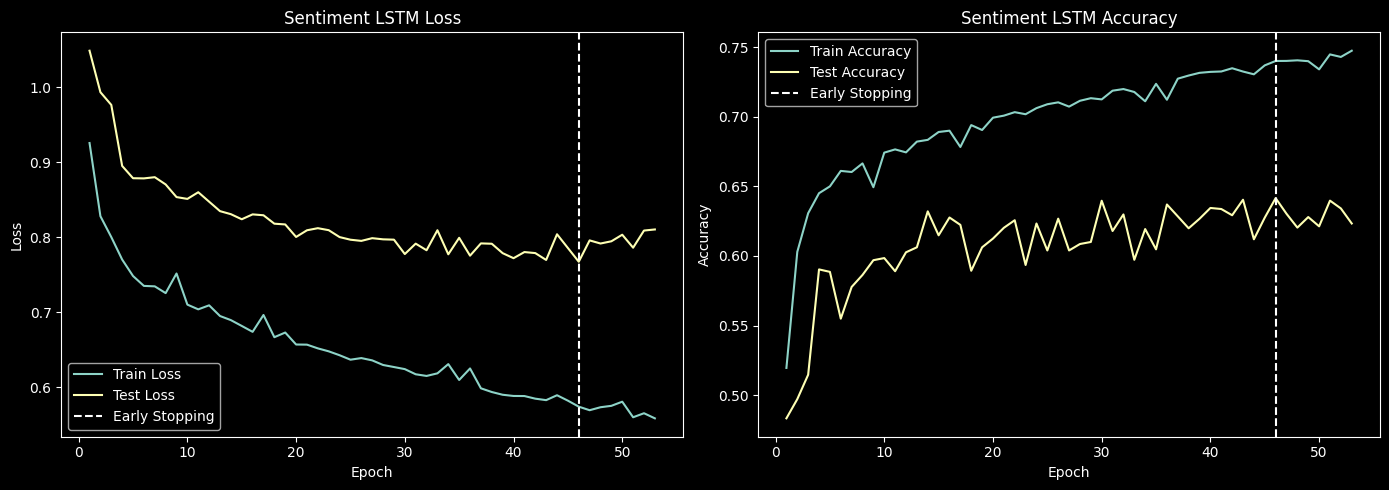

In [30]:
plot_results(metrics, patience=patience)

## Emotion

In [31]:
BATCH_SIZE = 256

TRAIN_TEXT_EMOTION = 'data/tweeteval/datasets/emotion/train_text.txt'
TRAIN_LABELS_EMOTION = 'data/tweeteval/datasets/emotion/train_labels.txt'
VAL_TEXT_EMOTION = 'data/tweeteval/datasets/emotion/test_text.txt'
VAL_LABELS_EMOTION = 'data/tweeteval/datasets/emotion/test_labels.txt'

train_loader = load_and_prepare_data(TRAIN_TEXT_EMOTION, TRAIN_LABELS_EMOTION, batch_size = BATCH_SIZE)
val_loader = load_and_prepare_data(VAL_TEXT_EMOTION, VAL_LABELS_EMOTION, batch_size = BATCH_SIZE)

In [32]:
input_dim = 100
hidden_dim = [32, 16]
output_dim = 3
n_layers = 2
learning_rate = 0.001
epochs = 100
patience = 7

model = LSTM(input_dim, hidden_dim, output_dim, n_layers).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

metrics['Emotion LSTM'] = fit(
    model, optimizer, loss_fn, 
    train_loader, val_loader, 
    epochs, patience
)

100%|██████████| 13/13 [00:00<00:00, 76.80it/s]


Epoch 0: train loss = 0.739 (acc: 0.430), validation loss = 0.770 (acc: 0.397)


100%|██████████| 13/13 [00:00<00:00, 133.91it/s]


Epoch 1: train loss = 0.715 (acc: 0.431), validation loss = 0.744 (acc: 0.387)


100%|██████████| 13/13 [00:00<00:00, 142.65it/s]


Epoch 2: train loss = 0.692 (acc: 0.430), validation loss = 0.733 (acc: 0.395)


100%|██████████| 13/13 [00:00<00:00, 128.62it/s]


Epoch 3: train loss = 0.686 (acc: 0.430), validation loss = 0.711 (acc: 0.398)


100%|██████████| 13/13 [00:00<00:00, 134.88it/s]


Epoch 4: train loss = 0.685 (acc: 0.430), validation loss = 0.700 (acc: 0.389)


100%|██████████| 13/13 [00:00<00:00, 120.09it/s]


Epoch 5: train loss = 0.684 (acc: 0.429), validation loss = 0.711 (acc: 0.395)


100%|██████████| 13/13 [00:00<00:00, 122.43it/s]


Epoch 6: train loss = 0.666 (acc: 0.431), validation loss = 0.695 (acc: 0.388)


100%|██████████| 13/13 [00:00<00:00, 123.41it/s]


Epoch 7: train loss = 0.636 (acc: 0.432), validation loss = 0.684 (acc: 0.392)


100%|██████████| 13/13 [00:00<00:00, 134.41it/s]


Epoch 8: train loss = 0.601 (acc: 0.444), validation loss = 0.679 (acc: 0.393)


100%|██████████| 13/13 [00:00<00:00, 90.00it/s]


Epoch 9: train loss = 0.577 (acc: 0.500), validation loss = 0.673 (acc: 0.496)


100%|██████████| 13/13 [00:00<00:00, 150.09it/s]


Epoch 10: train loss = 0.569 (acc: 0.515), validation loss = 0.632 (acc: 0.507)


100%|██████████| 13/13 [00:00<00:00, 127.91it/s]


Epoch 11: train loss = 0.550 (acc: 0.509), validation loss = 0.663 (acc: 0.476)


100%|██████████| 13/13 [00:00<00:00, 145.59it/s]


Epoch 12: train loss = 0.539 (acc: 0.518), validation loss = 0.622 (acc: 0.511)


100%|██████████| 13/13 [00:00<00:00, 135.05it/s]


Epoch 13: train loss = 0.514 (acc: 0.531), validation loss = 0.602 (acc: 0.505)


100%|██████████| 13/13 [00:00<00:00, 134.60it/s]


Epoch 14: train loss = 0.500 (acc: 0.538), validation loss = 0.612 (acc: 0.512)


100%|██████████| 13/13 [00:00<00:00, 125.82it/s]


Epoch 15: train loss = 0.492 (acc: 0.540), validation loss = 0.608 (acc: 0.502)


100%|██████████| 13/13 [00:00<00:00, 109.44it/s]


Epoch 16: train loss = 0.480 (acc: 0.537), validation loss = 0.595 (acc: 0.530)


100%|██████████| 13/13 [00:00<00:00, 121.45it/s]


Epoch 17: train loss = 0.484 (acc: 0.546), validation loss = 0.653 (acc: 0.530)


100%|██████████| 13/13 [00:00<00:00, 138.30it/s]


Epoch 18: train loss = 0.450 (acc: 0.561), validation loss = 0.604 (acc: 0.531)


100%|██████████| 13/13 [00:00<00:00, 137.51it/s]


Epoch 19: train loss = 0.449 (acc: 0.557), validation loss = 0.620 (acc: 0.505)


100%|██████████| 13/13 [00:00<00:00, 142.20it/s]


Epoch 20: train loss = 0.450 (acc: 0.555), validation loss = 0.653 (acc: 0.439)


100%|██████████| 13/13 [00:00<00:00, 139.34it/s]


Epoch 21: train loss = 0.465 (acc: 0.540), validation loss = 0.615 (acc: 0.439)


100%|██████████| 13/13 [00:00<00:00, 144.49it/s]


Epoch 22: train loss = 0.414 (acc: 0.577), validation loss = 0.564 (acc: 0.520)


100%|██████████| 13/13 [00:00<00:00, 141.62it/s]


Epoch 23: train loss = 0.413 (acc: 0.575), validation loss = 0.643 (acc: 0.445)


100%|██████████| 13/13 [00:00<00:00, 140.15it/s]


Epoch 24: train loss = 0.404 (acc: 0.585), validation loss = 0.601 (acc: 0.475)


100%|██████████| 13/13 [00:00<00:00, 135.38it/s]


Epoch 25: train loss = 0.383 (acc: 0.595), validation loss = 0.618 (acc: 0.465)


100%|██████████| 13/13 [00:00<00:00, 134.48it/s]


Epoch 26: train loss = 0.379 (acc: 0.599), validation loss = 0.597 (acc: 0.455)


100%|██████████| 13/13 [00:00<00:00, 123.22it/s]


Epoch 27: train loss = 0.379 (acc: 0.599), validation loss = 0.599 (acc: 0.463)


100%|██████████| 13/13 [00:00<00:00, 146.04it/s]


Epoch 28: train loss = 0.374 (acc: 0.598), validation loss = 0.637 (acc: 0.444)


100%|██████████| 13/13 [00:00<00:00, 139.56it/s]

Epoch 29: train loss = 0.358 (acc: 0.607), validation loss = 0.630 (acc: 0.444)
Early stopping triggered after 7 epochs without improvement


Early stopping at epoch 46
Early stopping at epoch 23


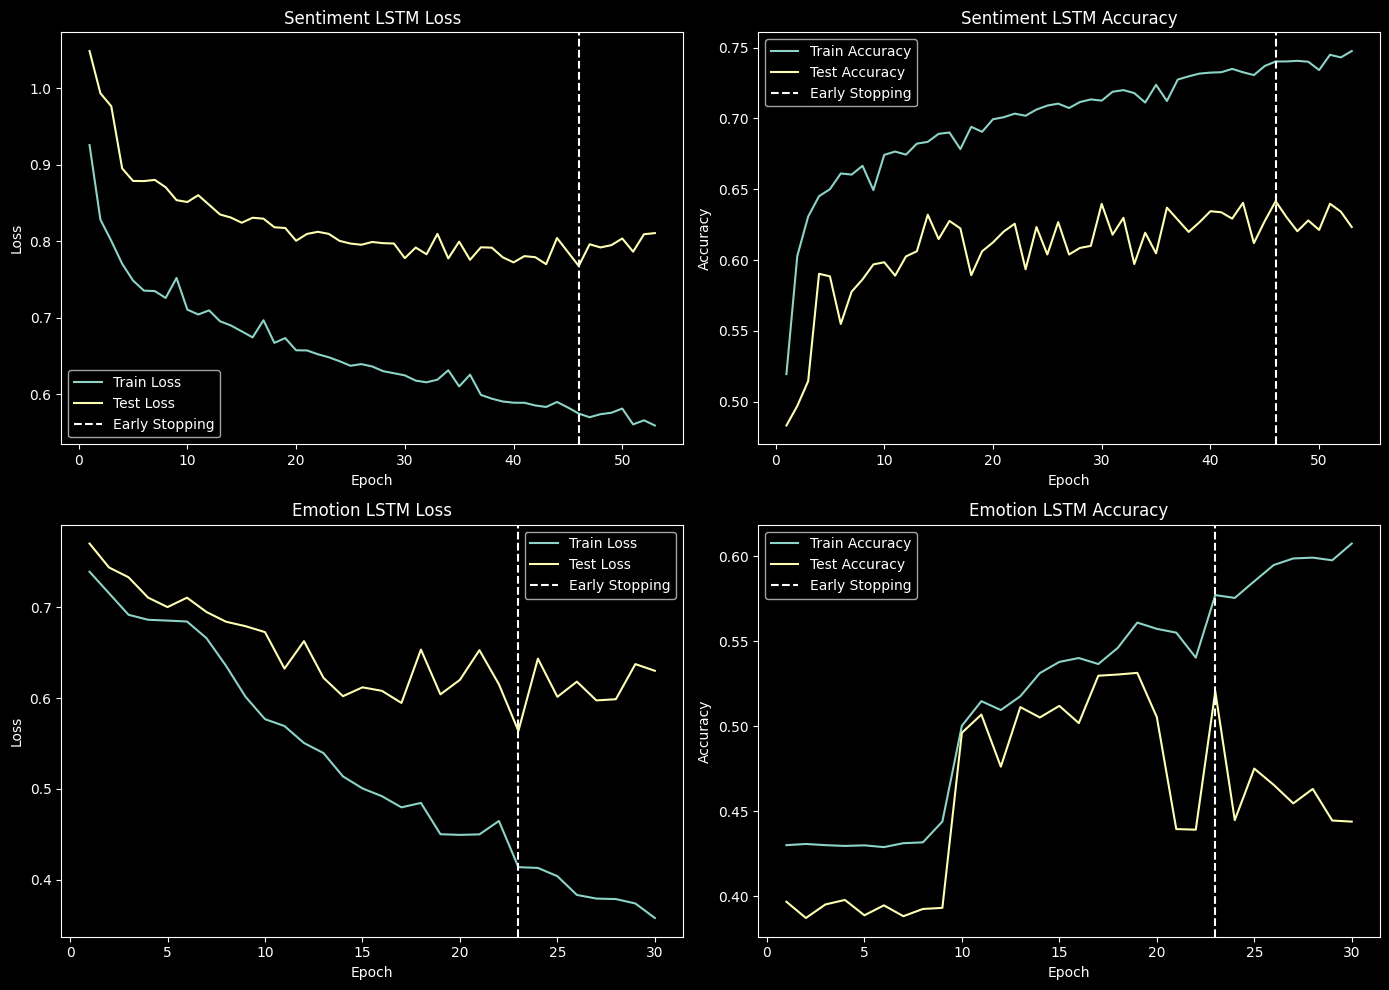

In [33]:
plot_results(metrics, patience=patience)

## Irony

In [34]:
BATCH_SIZE = 256

TRAIN_TEXT_IRONY = 'data/tweeteval/datasets/irony/train_text.txt'
TRAIN_LABELS_IRONY = 'data/tweeteval/datasets/irony/train_labels.txt'
VAL_TEXT_IRONY = 'data/tweeteval/datasets/irony/test_text.txt'
VAL_LABELS_IRONY = 'data/tweeteval/datasets/irony/test_labels.txt'

train_loader = load_and_prepare_data(TRAIN_TEXT_IRONY, TRAIN_LABELS_IRONY, batch_size = BATCH_SIZE)
val_loader = load_and_prepare_data(VAL_TEXT_IRONY, VAL_LABELS_IRONY, batch_size = BATCH_SIZE)

In [35]:
input_dim = 100
hidden_dim = [32, 16]
output_dim = 3
n_layers = 2
learning_rate = 0.001
epochs = 100
patience = 7

model = LSTM(input_dim, hidden_dim, output_dim, n_layers).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

metrics['Stance LSTM'] = fit(
    model, optimizer, loss_fn, 
    train_loader, val_loader, 
    epochs, patience
)

100%|██████████| 12/12 [00:00<00:00, 35.20it/s]


Epoch 0: train loss = 1.060 (acc: 0.499), validation loss = 1.099 (acc: 0.362)


100%|██████████| 12/12 [00:00<00:00, 56.07it/s]


Epoch 1: train loss = 1.046 (acc: 0.491), validation loss = 1.096 (acc: 0.392)


100%|██████████| 12/12 [00:00<00:00, 55.84it/s]


Epoch 2: train loss = 1.036 (acc: 0.506), validation loss = 1.115 (acc: 0.362)


100%|██████████| 12/12 [00:00<00:00, 56.70it/s]


Epoch 3: train loss = 1.035 (acc: 0.506), validation loss = 1.091 (acc: 0.406)


100%|██████████| 12/12 [00:00<00:00, 56.03it/s]


Epoch 4: train loss = 1.036 (acc: 0.506), validation loss = 1.098 (acc: 0.392)


100%|██████████| 12/12 [00:00<00:00, 56.79it/s]


Epoch 5: train loss = 1.034 (acc: 0.508), validation loss = 1.084 (acc: 0.421)


100%|██████████| 12/12 [00:00<00:00, 55.12it/s]


Epoch 6: train loss = 1.034 (acc: 0.508), validation loss = 1.092 (acc: 0.406)


100%|██████████| 12/12 [00:00<00:00, 53.27it/s]


Epoch 7: train loss = 1.037 (acc: 0.505), validation loss = 1.119 (acc: 0.348)


100%|██████████| 12/12 [00:00<00:00, 57.11it/s]


Epoch 8: train loss = 1.028 (acc: 0.517), validation loss = 1.122 (acc: 0.348)


100%|██████████| 12/12 [00:00<00:00, 54.32it/s]


Epoch 9: train loss = 1.039 (acc: 0.502), validation loss = 1.084 (acc: 0.421)


100%|██████████| 12/12 [00:00<00:00, 54.70it/s]


Epoch 10: train loss = 1.034 (acc: 0.508), validation loss = 1.099 (acc: 0.392)


100%|██████████| 12/12 [00:00<00:00, 56.31it/s]


Epoch 11: train loss = 1.045 (acc: 0.493), validation loss = 1.070 (acc: 0.450)


100%|██████████| 12/12 [00:00<00:00, 52.98it/s]


Epoch 12: train loss = 1.041 (acc: 0.499), validation loss = 1.122 (acc: 0.348)


100%|██████████| 12/12 [00:00<00:00, 51.27it/s]


Epoch 13: train loss = 1.037 (acc: 0.503), validation loss = 1.085 (acc: 0.421)


100%|██████████| 12/12 [00:00<00:00, 52.09it/s]


Epoch 14: train loss = 1.032 (acc: 0.511), validation loss = 1.077 (acc: 0.436)


100%|██████████| 12/12 [00:00<00:00, 56.10it/s]


Epoch 15: train loss = 1.026 (acc: 0.520), validation loss = 1.100 (acc: 0.392)


100%|██████████| 12/12 [00:00<00:00, 51.87it/s]


Epoch 16: train loss = 1.035 (acc: 0.508), validation loss = 1.091 (acc: 0.406)


100%|██████████| 12/12 [00:00<00:00, 47.33it/s]


Epoch 17: train loss = 1.037 (acc: 0.503), validation loss = 1.109 (acc: 0.377)


100%|██████████| 12/12 [00:00<00:00, 53.12it/s]


Epoch 18: train loss = 1.037 (acc: 0.505), validation loss = 1.084 (acc: 0.421)
Early stopping triggered after 7 epochs without improvement


Early stopping at epoch 46
Early stopping at epoch 23
Early stopping at epoch 12


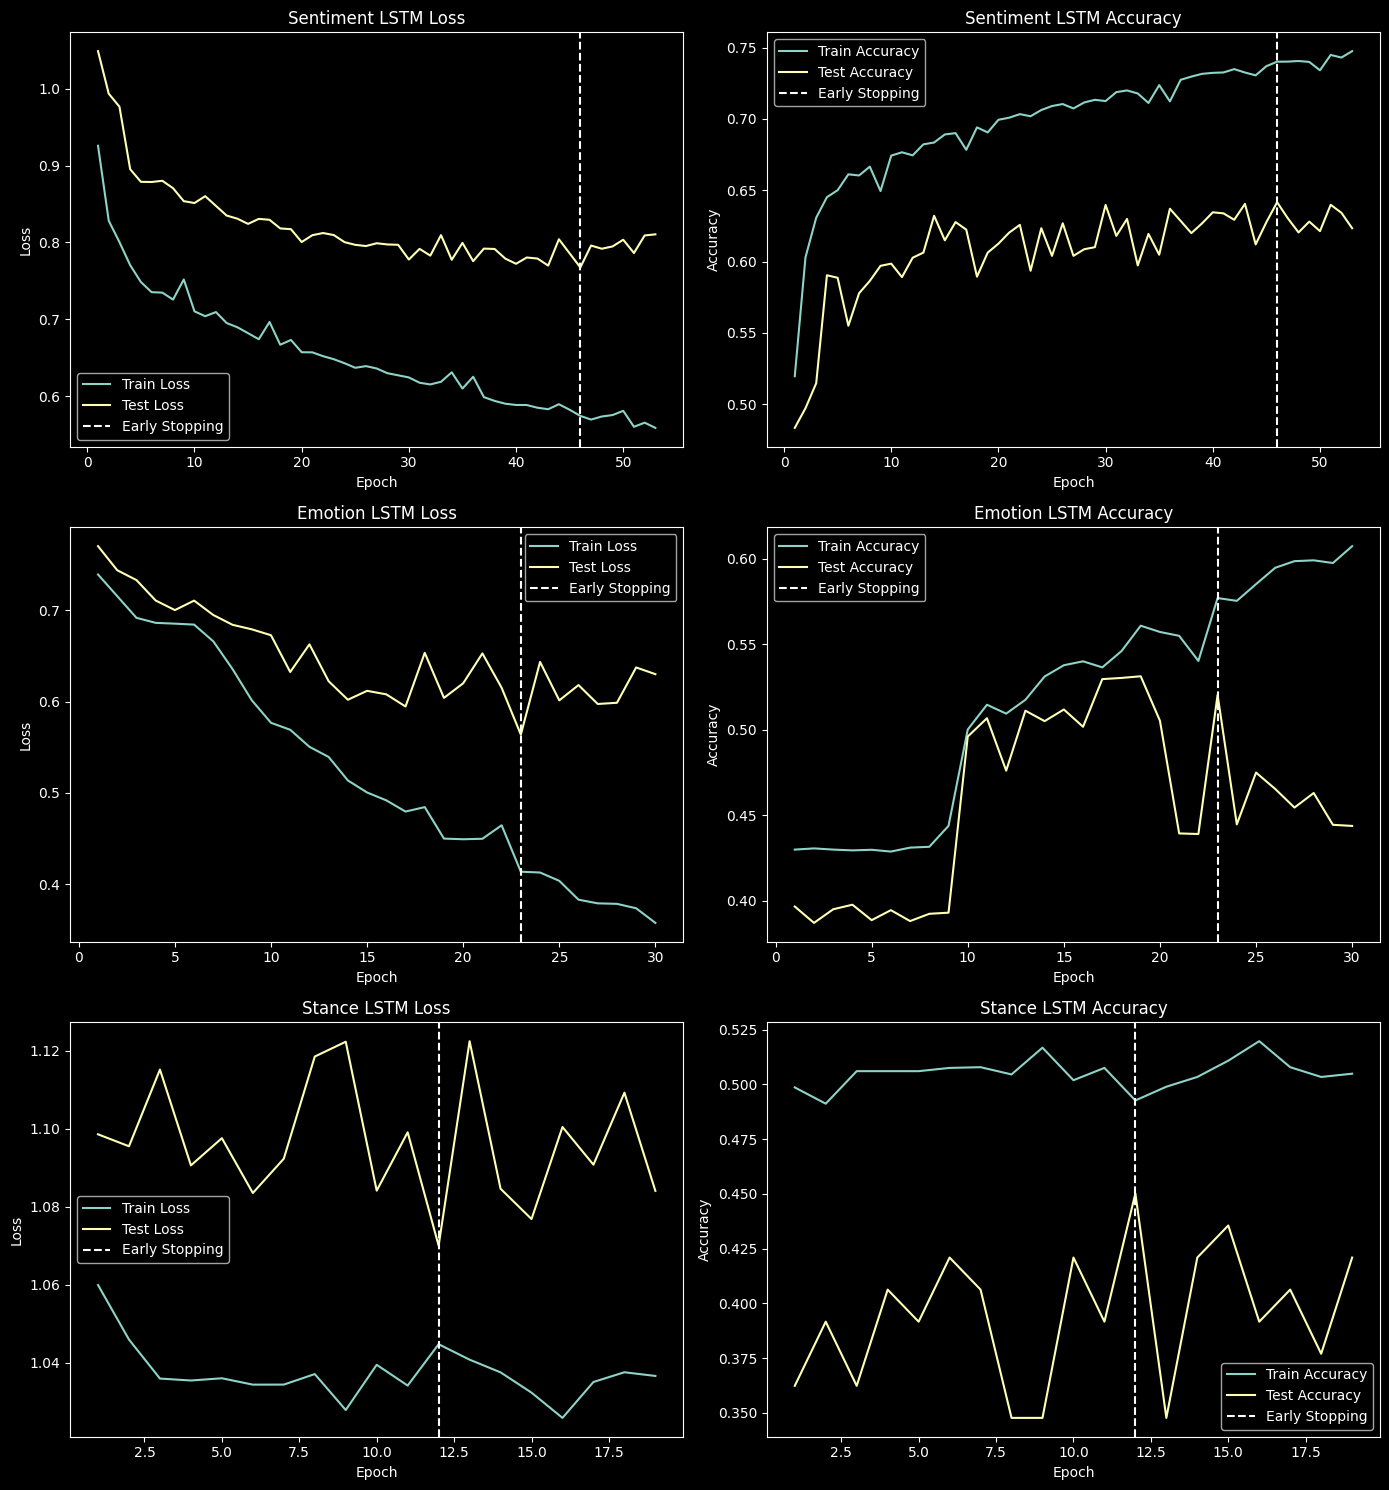

In [36]:
plot_results(metrics, patience=patience)

## Trenowanie modeli LR (fastText) dla SENTIMENT i EMOTION (2 pkt.)

In [53]:
import os

# Lista plików do sprawdzenia
files = [
    'data/tweeteval/datasets/sentiment/train_text.txt',
    'data/tweeteval/datasets/sentiment/train_labels.txt',
    'data/tweeteval/datasets/sentiment/test_text.txt',
    'data/tweeteval/datasets/sentiment/test_labels.txt',
    'data/tweeteval/datasets/sentiment/val_text.txt',
    'data/tweeteval/datasets/sentiment/val_labels.txt'
]

# Sprawdzanie, czy każdy plik istnieje
for file in files:
    if not os.path.exists(file):
        print(f"Brak pliku: {file}")
    else:
        print(f"Plik istnieje: {file}")


Plik istnieje: data/tweeteval/datasets/sentiment/train_text.txt
Plik istnieje: data/tweeteval/datasets/sentiment/train_labels.txt
Plik istnieje: data/tweeteval/datasets/sentiment/test_text.txt
Plik istnieje: data/tweeteval/datasets/sentiment/test_labels.txt
Plik istnieje: data/tweeteval/datasets/sentiment/val_text.txt
Plik istnieje: data/tweeteval/datasets/sentiment/val_labels.txt


In [42]:
# Dodanie prefiksu `__label__` do etykiet zbioru `sentiment`
!sed 's/^/__label__/g' data/tweeteval/datasets/sentiment/train_labels.txt > outs/train_labels_sent.txt
!sed 's/^/__label__/g' data/tweeteval/datasets/sentiment/test_labels.txt > outs/test_labels_sent.txt
!sed 's/^/__label__/g' data/tweeteval/datasets/sentiment/val_labels.txt > outs/val_labels_sent.txt

!paste -d " " data/tweeteval/datasets/sentiment/train_text.txt outs/train_labels_sent.txt > outs/train_sent.txt
!paste -d " " data/tweeteval/datasets/sentiment/test_text.txt outs/test_labels_sent.txt > outs/test_sent.txt
!paste -d " " data/tweeteval/datasets/sentiment/val_text.txt outs/val_labels_sent.txt > outs/val_sent.txt

In [43]:
# Dodanie prefiksu `__label__` do etykiet zbioru `emotion`
!sed 's/^/__label__/g' data/tweeteval/datasets/emotion/train_labels.txt > outs/train_labels_emo.txt
!sed 's/^/__label__/g' data/tweeteval/datasets/emotion/test_labels.txt > outs/test_labels_emo.txt
!sed 's/^/__label__/g' data/tweeteval/datasets/emotion/val_labels.txt > outs/val_labels_emo.txt

# Łączenie tekstów z etykietami
!paste -d " " outs/train_labels_emo.txt data/tweeteval/datasets/emotion/train_text.txt > outs/train_emo.txt
!paste -d " " outs/test_labels_emo.txt data/tweeteval/datasets/emotion/test_text.txt > outs/test_emo.txt
!paste -d " " outs/val_labels_emo.txt data/tweeteval/datasets/emotion/val_text.txt > outs/val_emo.txt

## Trening

In [44]:
# Trenowanie modelu dla `sentiment`
!~/Code/pwr/GSN/10/models/fastText/fasttext supervised -input outs/train_sent.txt -output models/sent_model -dim 20 -pretrainedVectors models/fasttext_tweetmodel_btc_sg_20_en.vec -autotune-validation outs/val_sent.txt 

Progress: 100.0% Trials:   61 Best score:  0.697000 ETA:   0h 0m 0s53s  0h 4m41s 3m42sh 2m57s2m50s 0.696500 ETA:   0h 2m33sm14s 0.697000 ETA:   0h 0m24s
Training again with best arguments
Read 0M words
Number of words:  106361
Number of labels: 3
Progress: 100.0% words/sec/thread:  841476 lr:  0.000000 avg.loss:  0.675703 ETA:   0h 0m 0s


In [45]:
# Trenowanie modelu dla `emotion`
!~/Code/pwr/GSN/10/models/fastText/fasttext supervised -input outs/train_emo.txt -output models/emo_model -dim 20 -pretrainedVectors models/fasttext_tweetmodel_btc_sg_20_en.vec -autotune-validation outs/val_emo.txt 

Progress: 100.0% Trials:   60 Best score:  0.697861 ETA:   0h 0m 0s 4m48ssm27s 2s  0h 3m45s0.697861 ETA:   0h 2m32s 1m 5ss  0h 0m23s0h 0m15ss
Training again with best arguments
Read 0M words
Number of words:  12887
Number of labels: 4
Progress: 100.0% words/sec/thread:  968744 lr:  0.000000 avg.loss:  0.438781 ETA:   0h 0m 0s


## Ewaluacja modeli na danych testowych dla zjawiska SENTIMENT i EMOTION (4 pkt.)

In [46]:
# Ewaluacja dla `sentiment`
!~/Code/pwr/GSN/10/models/fastText/fasttext test models/sent_model.bin outs/test_sent.txt

N	12284
P@1	0.62
R@1	0.62


In [47]:
# Ewaluacja dla `emotion`
!~/Code/pwr/GSN/10/models/fastText/fasttext test models/emo_model.bin outs/test_emo.txt

N	1421
P@1	0.687
R@1	0.687


In [48]:
# Przewidywania dla `sentiment`
!~/Code/pwr/GSN/10/models/fastText/fasttext predict models/sent_model.bin data/tweeteval/datasets/sentiment/test_text.txt | sed 's/__label__//g' > outs/predictions2/sentiment.txt

In [49]:
# Przewidywania dla `emotion`
!~/Code/pwr/GSN/10/models/fastText/fasttext predict models/emo_model.bin data/tweeteval/datasets/emotion/test_text.txt | sed 's/__label__//g' > outs/predictions2/emotion.txt

In [58]:
# Uruchomienie skryptu ewaluacji dla `sentiment`
!python data/tweeteval/evaluation_script.py --tweeteval_path data/tweeteval/datasets --predictions_path outs/predictions2 --task sentiment

0 {'precision': 0.649810366624526, 'recall': 0.5176233635448136, 'f1-score': 0.5762331838565022, 'support': 3972.0}
1 {'precision': 0.6328974318575705, 'recall': 0.6766043456291057, 'f1-score': 0.6540214913708889, 'support': 5937.0}
2 {'precision': 0.5549945906959971, 'recall': 0.648, 'f1-score': 0.5979020979020979, 'support': 2375.0}
accuracy 0.6196678606317161
macro avg {'precision': 0.6125674630593645, 'recall': 0.6140759030579731, 'f1-score': 0.609385591043163, 'support': 12284.0}
weighted avg {'precision': 0.6233043782215897, 'recall': 0.6196678606317161, 'f1-score': 0.6180186651794592, 'support': 12284.0}
------------------------------
TweetEval Score (sentiment): 0.6140759030579731


In [59]:
# Uruchomienie skryptu ewaluacji dla `emotion`
!python data/tweeteval/evaluation_script.py --tweeteval_path data/tweeteval/datasets --predictions_path outs/predictions2 --task emotion

0 {'precision': 0.6974664679582713, 'recall': 0.8387096774193549, 'f1-score': 0.7615947925142392, 'support': 558.0}
1 {'precision': 0.7247386759581882, 'recall': 0.5810055865921788, 'f1-score': 0.6449612403100775, 'support': 358.0}
2 {'precision': 0.5263157894736842, 'recall': 0.3252032520325203, 'f1-score': 0.4020100502512563, 'support': 123.0}
3 {'precision': 0.6718346253229974, 'recall': 0.680628272251309, 'f1-score': 0.6762028608582574, 'support': 382.0}
accuracy 0.6868402533427164
macro avg {'precision': 0.6550888896782853, 'recall': 0.6063866970738407, 'f1-score': 0.6211922359834576, 'support': 1421.0}
weighted avg {'precision': 0.682632233703304, 'recall': 0.6868402533427164, 'f1-score': 0.678130012162359, 'support': 1421.0}
------------------------------
TweetEval Score (emotion): 0.6211922359834576
